In [1]:
import pandas as pd 
pd.set_option('display.max_columns', 100)
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import norm, skew
from scipy import stats

train_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')

train_id = train_set['Id']
test_id = test_set['Id']
train_set.head()

# 移除离群点
train_set.drop(train_set[train_set['GrLivArea'] > 4000].index, axis=0, inplace=True)

(mean, std) = norm.fit(train_set['SalePrice'])
print('mean: %f,  std: %f' % (mean, std))

# apply log(1+x) to column SalePrice
train_set['SalePrice'] = train_set['SalePrice'].apply(np.log1p)

y_train = train_set['SalePrice'].values
n_train = train_set.shape[0]
n_test = test_set.shape[0]
x_train_df = train_set.drop('SalePrice', axis=1)
x_test_df = test_set 
print(x_train_df.shape, x_test_df.shape)

## missing data
df = pd.concat((x_train_df, x_test_df)).reset_index(drop=True)

## input missing value
df['PoolQC'].fillna('None', inplace=True)
df['MiscFeature'].fillna('None', inplace=True)
df['Alley'].fillna('None', inplace=True)
df['Fence'].fillna('None', inplace=True)
df['FireplaceQu'].fillna('None', inplace=True)

# Since the area of each street connected to the house, 
# probably most likely have a similary area to other houses in its neighboor
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df[col] = df[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df[col] = df[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
           'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df[col] = df[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure',
            'BsmtFinType1', 'BsmtFinType2'):
    df[col] = df[col].fillna('None')

df['MasVnrType'].fillna('None', inplace=True)
df['MasVnrArea'].fillna(0, inplace=True)
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
df = df.drop('Utilities', axis=1)
df['Functional'].fillna('Typ', inplace=True)

df['Electrical'].fillna(df['Electrical'].mode()[0], inplace=True)
df['KitchenQual'].fillna(df['KitchenQual'].mode(), inplace=True)
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['SaleType'].fillna(df['SaleType'].mode()[0], inplace=True)
df['MSSubClass'].fillna(df['MSSubClass'].mode()[0], inplace=True)

df.isnull()[df.isnull() != 0].index

df['MSSubClass'] = df['MSSubClass'].apply(str)
df['OverallCond'] = df['OverallCond'].astype(str)
df['YrSold'] = df['YrSold'].astype(str)
df['MoSold'] = df['MoSold'].astype(str)

train_set.drop('Id', axis=1, inplace=True)
test_set.drop('Id', axis=1, inplace=True)
df.drop('Id', axis=1, inplace=True)

# label encode
# 将特征稀疏的特征，在本列编码
from sklearn.preprocessing import LabelEncoder 

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
       'ExterQual', 'ExterCond', 'HeatingQC', 'PoolQC', 'KitchenQual', 
       'BsmtFinType1', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure',
       'GarageFinish', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'Alley',
       'CentralAir', 'MSSubClass', 'OverallCond', 'YrSold', 'MoSold')

for col in cols:
    le = LabelEncoder()
    le.fit(list(df[col].values))
    df[col] = le.transform(list(df[col].values))

# # dummies
# df = pd.get_dummies(df)

# x_train = df[:n_train].values
# x_test = df[n_train:].values

mean: 180151.233516,  std: 76670.249891
(1456, 80) (1459, 80)


## modeling

In [ ]:
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.svm import SVR 
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import RobustScaler 
from sklearn.model_selection import KFold, cross_val_score 
from sklearn.metrics import mean_squared_error 
from mlxtend.regressor import StackingCVRegressor 
from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor 


kfold = KFold(n_splits=10, shuffle=True, random_state=42)

def remsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def cv_rmse(model, X=x_train):
    error = 'neg_mean_squared_error'
    rmse = np.sqrt(-cross_val_score(model, X, y_train, scoring='neg_mean_squared_error', cv=kfolds))
    return rmse 

# # ridge
alpha_ridge = [14, 14.3, 14.6, 14.9, 15.2, 15.5]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alpha_ridge, cv=kfold))
# #lasso
alpha_lasso = [0.0001, 0.0003, 0.001, 0.003, 0.01]
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e5, 
                                                alphas=alpha_lasso, 
                                                random_state=42, 
                                                cv=kfolds))
# # elaticnet
alpha_ela = [0.0001, 0.0003, 0.001, 0.003, 0.01]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 1]
elasticnet = make_pipeline(RobustScaler(), ElasticNetCV(max_iter=1e5, 
                                                          alphas=alpha_ela, 
                                                          cv=kfolds, 
                                                          l1_ratio=e_l1ratio))
# svr
svr = make_pipeline(RobustScaler(), SVR(C=0.4, 
                                         epsilon=0.008,
                                         gamma=0.0003))
# # gradientboostregressor
gbr = GradientBoostingRegressor(n_estimators=3000, 
                                learning_rate=0.05, 
                               max_depth=4,
                               max_features='sqrt',
                               min_samples_leaf=15,
                               min_samples_split=10,
                               loss='huber',
                               random_state=42)

# ligbtgbm
lgb = LGBMRegressor(objective='regression',
                   learning=0.01,
                    e_estimators=5000,
                    max_depth=4,
                    num_leaves=3,
                    feature_fraction=0.2,
                    cat_smooth=0,
                    bagging_fraction=0.9,
                    bagging_fraq=3,
                    verbose=-1
                   )
# xgboost
xgb = XGBRegressor(learning_rate=0.01,
                   n_estimators=3460,
                   max_depth=3, 
                   min_child_weight=0,
                   gamma=0, 
                   subsample=0.7,
                   colsample_bytree=0.7,
                   objective='reg:squarederror',
                   nthread=-1,
                   scale_pos_weight=1,
                   seed=27,
                   reg_alpha=0.00006)
# stack model
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet, gbr, lgb, xgb),
                               meta_regressor=lgb,
                               use_features_in_secondary=True)

# score = cv_rmse(ridge)
# print('ridge 模型得分：{:.4f} ({:.4f})'.format(score.mean(), score.std()))

# score = cv_rmse(lasso)
# print('lasso 模型得分：{:.4f} ({:.4f})'.format(score.mean(), score.std()))

# score = cv_rmse(elasticnet)
# print('elasticnet 模型得分：{:.4f} ({:.4f})'.format(score.mean(), score.std()))

# score = cv_rmse(svr)
# print('svr 模型得分：{:.4f} ({:.4f})'.format(score.mean(), score.std()))

# score = cv_rmse(gbr)
# print('gradientboostregressor 模型得分：{:.4f} ({:.4f})'.format(score.mean(), score.std()))

# score = cv_rmse(lgb)
# print('lightgbm 模型得分：{:.4f} ({:.4f})'.format(score.mean(), score.std()))

# score = cv_rmse(xgb)
# print('xgboost 模型得分：{:.4f} ({:.4f})'.format(score.mean(), score.std()))

# score = cv_rmse(stack_gen)
# print('stacken model 模型得分：{:.4f} ({:.4f})'.format(score.mean(), score.std()))

In [324]:
# 用调好参数的模型拟合训练全部数据
# ridge_ = ridge.fit(x_train, y_train)
# lasso_ = lasso.fit(x_train, y_train)
# elasticnet_ = elasticnet.fit(x_train, y_train)
# svr_ = svr.fit(x_train, y_train)
# gbr_ = gbr.fit(x_train, y_train)
# lgb_ = lgb.fit(x_train, y_train)
# xgb_ = xgb.fit(x_train, y_train)

def blend_models_predict(x_test):
    return ((0.1 * elasticnet.predict(x_test))+
            (0.1 * ridge.predict(x_test))+
            (0.1 * lasso.predict(x_test))+
            (0.0 * svr.predict(x_test))+
            (0.1 * gbr.predict(x_test))+
            (0.1 * lgb.predict(x_test))+
            (0.5 * xgb.predict(x_test))
#             0.1 * elasticnet_.predict(x_test),
           )

# 融合后，训练模型对元数据拟合时均方根误差
# print('训练数据拟合的均方根误差：', remsle(y_train, blend_models_predict(x_train)))

In [323]:
xgb.predict(x_test)

array([11.729377, 12.005816, 12.131836, ..., 11.967694, 11.656274,
       12.327476], dtype=float32)

In [325]:
predictions = np.expm1(blend_models_predict(x_test))
submission = pd.DataFrame()
submission['Id'] = test_id
submission['SalePrice'] = predictions
submission.to_csv('submission_2020_03_01.csv', index=False)

In [ ]:
submission

In [ ]:
# svr 调参
paramaters = {
    'C':[0.01, 0.03, 0.1, 0.3, 1, 3, 10],
    'gamma': [0.001, 0.003, 0.01, 0.03, 0.1],
}

svr = SVR(kernel='linear')
gscv_svr = GridSearchCV(svr,
                       param_grid = paramaters,
                       cv=5,
                       verbose=-1)
gscv_svr.fit(x_train, y_train)

In [ ]:
paramaters = {
    'max_depth': [4],
    'num_leaves': [3],
    'feature_fraction': [0.2],
    'cat_smmoth': [1],
    'bagging_fraction': [0.9],
    'bagging_fraq': [3]
}

gbm = lgb.LGBMRegressor(
                objective = 'regression',
                learning_rate = 0.01,
                n_estimators = 5000,
                verbose = -1
)

gscv = GridSearchCV(gbm,
                   param_grid = paramaters,
                   cv = 5,
                   n_jobs = -1)

gscv.fit(x_train, y_train)

## modeling

linear_reg:-0.015115 (0.004384)
knn:-0.048823 (0.005244)
SVR:-0.156528 (0.020539)
decision_tree:-0.037592 (0.007852)


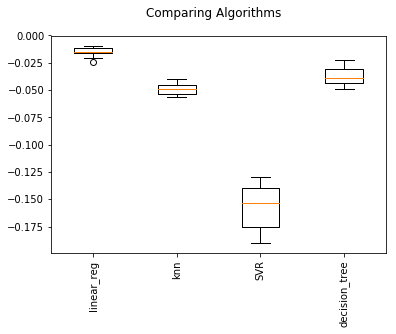

In [201]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR 
from sklearn.tree import DecisionTreeRegressor 

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

models = []
models.append(('linear_reg', LinearRegression()))
models.append(('knn', KNeighborsRegressor()))
models.append(('SVR', SVR()))
models.append(('decision_tree', DecisionTreeRegressor()))

names = []
predictions = []
error = 'neg_mean_squared_error'
for name, model in models:
    fold = KFold(n_splits=10, random_state=0)
    result = cross_val_score(model, x_train, y_train, cv=fold, scoring=error)
    predictions.append(result)
    names.append(name)
    msg = '%s:%f (%f)' % (name, result.mean(), result.std())
    print(msg)


## Create pipeline with Standardization scale and models 

### Standardize the dataset

scaler_lg: -42299828435270451200.000000 (111249075729436999680.000000)
scale_KNN: -0.039544 (0.008133)
scale_SVR: -0.031837 (0.007543)
scale_decision: -0.038644 (0.008253)
[array([-2.35386430e+16, -2.10108418e+17, -4.28381611e+18, -3.71453484e+15,
       -2.35728473e+18, -5.50305990e+17, -3.76904730e+18, -1.09732242e+18,
       -3.74582364e+20, -3.61207825e+19]), array([-0.03775905, -0.04253397, -0.04238442, -0.04563515, -0.05259116,
       -0.02740558, -0.04524507, -0.02692457, -0.03091265, -0.04404923]), array([-0.03696491, -0.02866518, -0.03998731, -0.03476248, -0.04472446,
       -0.02519728, -0.03448589, -0.01978869, -0.02207881, -0.03171623]), array([-0.04559179, -0.04219368, -0.03927766, -0.0459086 , -0.04406778,
       -0.02143378, -0.03340501, -0.04624315, -0.02654237, -0.04178102])]


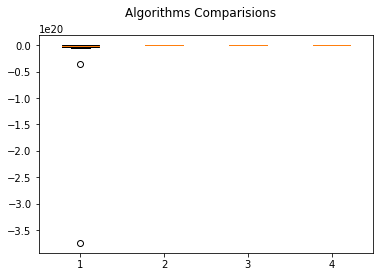

In [202]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

pipelines = []
pipelines.append(('scaler_lg', Pipeline([('scaler', MinMaxScaler()), ('lg', LinearRegression())])))
pipelines.append(('scale_KNN', Pipeline([('scaler', StandardScaler()), ('KNN', KNeighborsRegressor())])))
pipelines.append(('scale_SVR', Pipeline([('scaler', StandardScaler()), ('SVR', SVR())])))
pipelines.append(('scale_decision', Pipeline([('scaler', StandardScaler()), ('decision', DecisionTreeRegressor())])))

predictions = []
names = []
for name, model in pipelines:
    fold = KFold(n_splits=10, random_state=5)
    result = cross_val_score(model, x_train, y_train, cv=fold, scoring=error)
    predictions.append(result)
    names.append(name)
    msg = '%s: %f (%f)' % (name, result.mean(), result.std())
    print(msg)

In [211]:
# SVR tuning 
from sklearn.model_selection import GridSearchCV

scaler = StandardScaler().fit(x_train)
rescaledx = scaler.transform(x_train)

param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.2, 0.4, 0.6, 0.8, 1.0]
}

model = SVR()
fold = KFold(n_splits=10, random_state=42)

grid = GridSearchCV(estimator=model,
                   param_grid=param_grid,
                   scoring=error,
                   cv=fold)
grid_result = grid.fit(rescaledx, y_train)
print('Best: %f useing %s' % (grid_result.best_score_, grid_result.best_params_))

Best: -0.015294 useing {'C': 0.4, 'kernel': 'linear'}


In [212]:
# DecisionTreeRegressor Tuning
scaler = StandardScaler().fit(x_train)
rescalex = scaler.transform(x_train)

criterion = ['mse', 'friedman_mse', 'mae']
param_grid = dict(criterion = criterion)

model = DecisionTreeRegressor()
fold = KFold(n_splits=10, random_state=42)
grid = GridSearchCV(estimator=model,
                   param_grid = param_grid,
                   scoring = error,
                   cv=fold)
grid_result = grid.fit(rescaledx, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.038076 using {'criterion': 'friedman_mse'}


scaledAB : -0.029019 (0.003039)
scaledGBR : -0.015235 (0.004337)
scaledRF : -0.020676 (0.003583)
scaledETR : -0.019509 (0.004989)


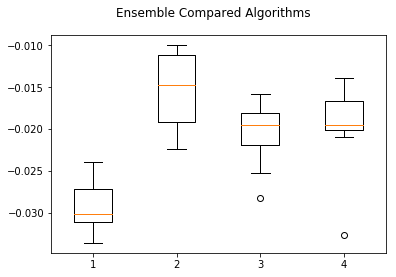

In [214]:
# Ensemble and Boosting algorithm to improve performance 
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import ExtraTreesRegressor 

ensembles = []
ensembles.append(('scaledAB', Pipeline([('scale', StandardScaler()), ('AB', AdaBoostRegressor())])))
ensembles.append(('scaledGBR', Pipeline([('scale', StandardScaler()), ('GBR', GradientBoostingRegressor())])))
ensembles.append(('scaledRF', Pipeline([('scale', StandardScaler()), ('RF', RandomForestRegressor())])))
ensembles.append(('scaledETR', Pipeline([('scale', StandardScaler()), ('ETR', ExtraTreesRegressor())])))

results = []
names = []
for name, model in ensembles:
    fold = KFold(n_splits=10, random_state=5)
    result = cross_val_score(model, x_train, y_train, cv=fold, scoring=error)
    results.append(result)
    names.append(name)
    msg = '%s : %f (%f)'% (name, result.mean(), result.std())
    print(msg)

fig = plt.figure()
fig.suptitle('Ensemble Compared Algorithms')
plt.boxplot(results)
plt.show()

In [258]:
# ExtraTreesRegressor Tuning 
scaler = StandardScaler().fit(x_train)
rescaledx = scaler.transform(x_train)

n_estimators = [5, 10, 20, 30, 40, 50, 100, 200]
param_grid = dict(n_estimators=n_estimators)
model = ExtraTreesRegressor()
fold = KFold(n_splits=10, random_state=5)
grid_etr = GridSearchCV(estimator=model, param_grid=param_grid, scoring=error-, cv=fold)
grid_etr = grid_etr.fit(x_train, y_train)

# print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))

In [259]:
print(grid_etr.best_score_)

etr_pred = np.expm1(grid_etr.best_estimator_.predict(x_test))
etr_pred

-0.017118454433971274


array([113766.19226501, 152389.79076575, 174738.45604329, ...,
       146615.91406782, 112115.41260962, 226064.29725796])

In [260]:
np.sqrt(0.017118454433971274)

0.13083751157054033

In [223]:
# GradientBoostingRegressor Tuning 
scaler = StandardScaler().fit(x_train)
rescaledx = scaler.transform(x_train)

learning_rate = [0.1, 0.2, 0.3, 0.4, 0.5]
n_estimators = [5, 10, 20, 30, 40, 50, 100, 200]
param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate)

model = GradientBoostingRegressor()
fold = KFold(n_splits=10, random_state=5)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=error, cv=fold)
grid_result = grid.fit(rescaledx, y_train)

print("Best: %f using: %s" % (grid_result.best_score_, grid_result.best_params_))

Best: -0.014804 using: {'learning_rate': 0.2, 'n_estimators': 200}


In [255]:
grid_gbr = grid.best_estimator_.fit(x_train, y_train)
gbr_pred = np.expm1(grid_gbr.predict(x_test))

## Finalize Model

In [230]:
from sklearn.metrics import mean_squared_error 

scaler = StandardScaler().fit(x_train)
scaler_x = scaler.transform(x_train)
model = GradientBoostingRegressor(random_state=5, n_estimators=200, learning_rate=0.2)
model.fit(scaler_x, y_train)

scaledx_test = scaler.transform(x_test)
y_pred = model.predict(scaledx_test)

In [239]:
sub = pd.DataFrame()
sub['Id'] = test_id 
sub['SalePrice'] = np.expm1(y_pred)*1.01
sub.to_csv('submission_2020_02_29.csv', index=False)

In [ ]:
# lightgbm
import lightgbm as lgb 

paramaters = {
    'max_depth': [4],
    'num_leaves': [3],
    'feature_fraction': [0.2],
    'cat_smmoth': [1],
    'bagging_fraction': [0.9],
    'bagging_fraq': [3],
    'cat_smooth': [0]
}

gbm = lgb.LGBMRegressor(
                objective = 'regression',
                learning_rate = 0.01,
                n_estimators = 5000,
                verbose = -1
)

gscv = GridSearchCV(gbm,
                   param_grid = paramaters,
                   cv = 5,
                   n_jobs = -1)

gscv.fit(x_train, y_train)

In [ ]:
gscv.best_score_

In [ ]:
lgb_pred = np.expm1(gscv.best_estimator_.predict(x_test))

sub = pd.DataFrame()
sub['Id'] = test_id 
sub['SalePrice'] = 0.7*lgb_pred + 0.2*gbr_pred + 0.1*etr_pred
sub.to_csv('submission_2020_02_29.csv', index=False)